In [27]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# Hotel Reservation Cancellations

In [2]:
url = 'https://raw.githubusercontent.com/pedroteche-ih/DAFT_MEX_202209/main/data/tb_hotel_traintest.csv'
tb_hotel = pd.read_csv(url)

## A bit of data cleaning

In [5]:
# Cleaning NAs
tb_hotel['children'] = tb_hotel['children'].fillna(0)
tb_hotel['is_company'] = np.where(tb_hotel['company'].isna(), 0, 1)
tb_hotel['is_agent'] = np.where(tb_hotel['agent'].isna(), 0, 1)
tb_hotel = tb_hotel.drop(['company', 'agent'], axis = 1).dropna()

## Creating Train/Test Sets

In [6]:
X = tb_hotel[['lead_time', 'is_company']]
y = tb_hotel['is_cancelled']
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Non-linear Classification Techniques

## Building our Baseline Classifier

In [7]:
from sklearn.linear_model import LogisticRegression

In [9]:
log_fit = LogisticRegression()
log_fit.fit(X_train, y_train)

LogisticRegression()

In [31]:
tb_test = X_test.copy()
tb_test['is_cancelled'] = y_test
tb_test['pred_log_is_cancelled'] = log_fit.predict(X_test)
tb_test['pred_prob_log'] = log_fit.predict_proba(X_test)[:,1]

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

F1-Score: 0.388631090487239


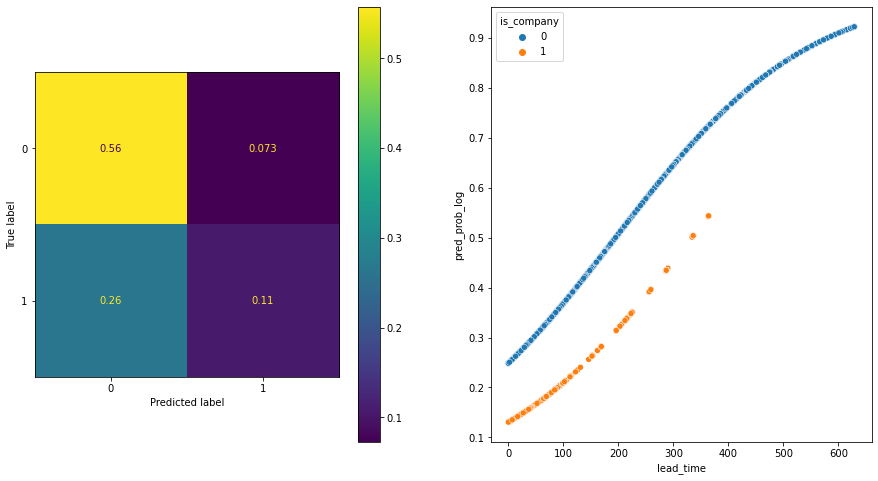

In [34]:
conf_mat = confusion_matrix(tb_test['is_cancelled'], tb_test['pred_log_is_cancelled'], normalize = 'all')
fig, ax = plt.subplots(1, 2, figsize = (15, 8))
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot(ax = ax[0]);
sns.scatterplot(data = tb_test, x = 'lead_time', y = 'pred_prob_log', hue = 'is_company')
f1_score_test = f1_score(tb_test['is_cancelled'], tb_test['pred_log_is_cancelled'])
print(f"F1-Score: {f1_score_test}")


# kNN Classifier

In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [36]:
knn_fit = KNeighborsClassifier(n_neighbors=5)
knn_fit.fit(X_train, y_train)

KNeighborsClassifier()

In [37]:
tb_test['pred_knn_is_cancelled'] = knn_fit.predict(X_test)
tb_test['pred_prob_knn'] = knn_fit.predict_proba(X_test)[:,1]

F1-Score: 0.4899226384364821


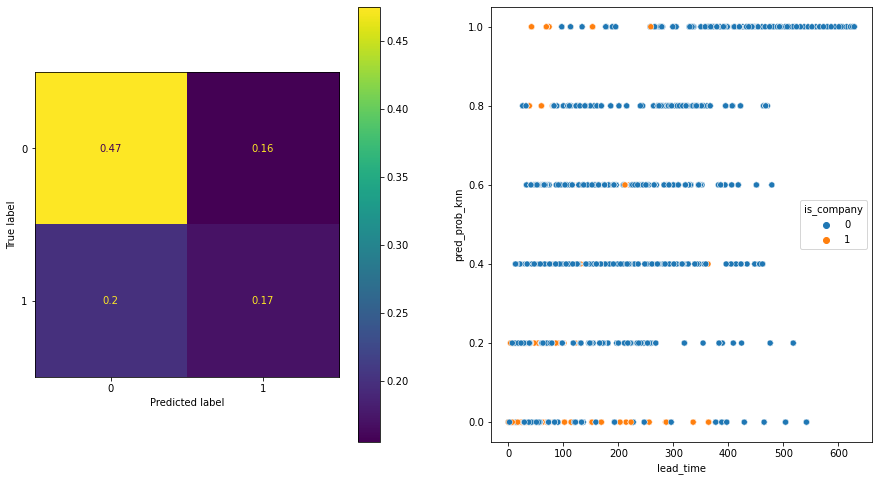

In [38]:
conf_mat = confusion_matrix(tb_test['is_cancelled'], tb_test['pred_knn_is_cancelled'], normalize = 'all')
fig, ax = plt.subplots(1, 2, figsize = (15, 8))
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot(ax = ax[0]);
sns.scatterplot(data = tb_test, x = 'lead_time', y = 'pred_prob_knn', hue = 'is_company')
f1_score_test = f1_score(tb_test['is_cancelled'], tb_test['pred_knn_is_cancelled'])
print(f"F1-Score: {f1_score_test}")


# Ensemble Methods

In [39]:
import catboost as cat

In [47]:
cat_fit = cat.CatBoostClassifier(iterations=5000, depth=16, od_type="Iter", od_wait=500, verbose = False)
cat_fit.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
tb_test['pred_cat_is_cancelled'] = cat_fit.predict(X_test)
tb_test['pred_prob_cat'] = cat_fit.predict_proba(X_test)[:,1]

F1-Score: 0.3690133113764238


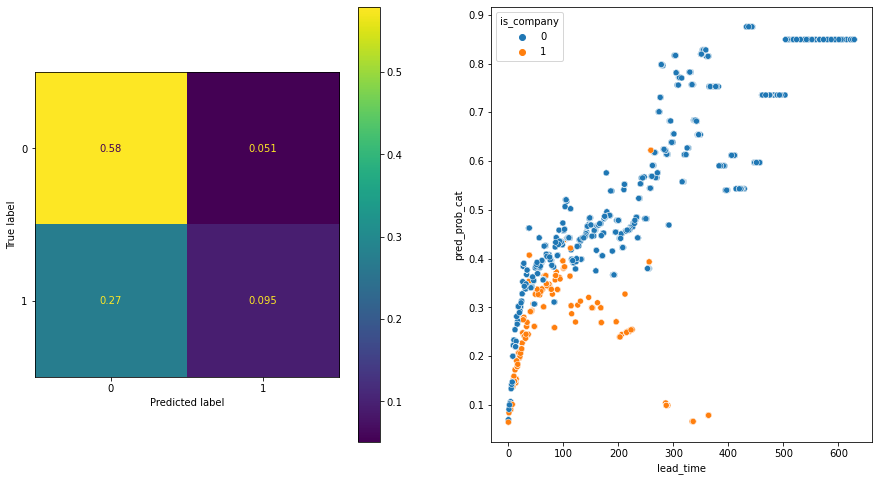

In [ ]:
conf_mat = confusion_matrix(tb_test['is_cancelled'], tb_test['pred_cat_is_cancelled'], normalize = 'all')
fig, ax = plt.subplots(1, 2, figsize = (15, 8))
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot(ax = ax[0]);
sns.scatterplot(data = tb_test, x = 'lead_time', y = 'pred_prob_cat', hue = 'is_company')
f1_score_test = f1_score(tb_test['is_cancelled'], tb_test['pred_cat_is_cancelled'])
print(f"F1-Score: {f1_score_test}")


# Neural Networks

**Hyperparameters:**

1. `hidden_layer_sizes` tuple containing the number of neurons on each hidden layer;
1. `activation` string (‘identity’, ‘logistic’, ‘tanh’, ‘relu’) determining activation function of hidden layer.

In [44]:
from sklearn.neural_network import MLPClassifier

In [ ]:
relu_fit = MLPClassifier(hidden_layer_sizes = (50, 50, 50), activation = 'relu')
relu_fit.fit(X_train, y_train)

In [ ]:
tb_test['pred_relu_is_cancelled'] = relu_fit.predict(X_test)
tb_test['pred_prob_relu'] = relu_fit.predict_proba(X_test)[:,1]

In [ ]:
conf_mat = confusion_matrix(tb_test['is_cancelled'], tb_test['pred_nn_is_cancelled'], normalize = 'all')
fig, ax = plt.subplots(1, 2, figsize = (15, 8))
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot(ax = ax[0]);
sns.scatterplot(data = tb_test, x = 'lead_time', y = 'pred_prob_nn', hue = 'is_company')
f1_score_test = f1_score(tb_test['is_cancelled'], tb_test['pred_nn_is_cancelled'])
print(f"F1-Score: {f1_score_test}")
